# Local Area Unemployment and Employment Statistics


In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

# Import libraries and adjust settings
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
plt.rc('font', family='Lato')

### MSA-level unemployment change

In [2]:
# CSV file contains city names, their BLS codes (Metropolitan 
# MTAs/NECTAs only), and their latitude and longitude
MSA = pd.read_csv('shapefiles/MSA.csv')

# BLS flat file contains the unemployment rate by month since 2015
url = 'https://download.bls.gov/pub/time.series/la/la.data.60.Metro'
df = pd.read_table(url, sep='\s+', dtype='object')

In [3]:
date = lambda x: x['year'].astype('str') + '-' + x['period'].str[1:] + '-01'

data = (df[df['series_id'].isin(MSA['fullcode']) & ~df['period'].isin(['M13'])]
          .assign(DATE = date)
          .set_index(['series_id','DATE'])
          .value).unstack().T.dropna().astype('float')

datelt = pd.to_datetime(data.index[-1])

data = data.iloc[-3:].mean() - data.iloc[-6:-3].mean()
text = datelt.strftime('%B %Y')
write_txt(text_dir / 'unemp_map_date.txt', text)
print(text)

data = data.rename('value')

ms = MSA.set_index('fullcode').join(data)
ms['color'] = np.where(ms.value > 0, 'greenyellow', np.where(ms.value < 0, 'lightblue', 'gray'))
ms['size'] = np.where(abs(ms.value) > 0, (abs(ms.value*3)), 1)

October 2021


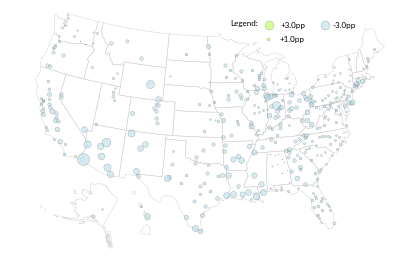

In [4]:
# Draw map
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

fig = plt.figure(figsize=(9.0,4.5))

m.readshapefile('shapefiles/states', 'st', drawbounds=True, color='lightgrey')

ax = plt.gca()
   
for info, shape in zip(m.st_info, m.st):
    if info['STATE_NAME'] == 'Hawaii':
        shape2 = [[x + 5200000, y - 1400000] for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5)) 
    elif info['STATE_NAME'] == 'Alaska':
        shape2 = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5))    
        
# Plot each location, value, and color as identified in the previous section        
for index, row in ms.iterrows():
    x, y = m(row['longitude'], row['latitude'])
    if row['fullname'].endswith('HI'):
        x = x + 5200000
        y = y - 1400000
    if row['fullname'].endswith('AK'):
        x = x * 0.34 + 1200000
        y = y * 0.34 - 1300000
    m.plot(x, y, marker='o', color=row['color'], alpha=0.5, markersize=row['size'], 
           markeredgecolor='black', markeredgewidth=.25)

x, y = m(-86.4, 48.4)
m.plot(x, y, marker='o', color='greenyellow', alpha=0.5, markersize=3, 
       markeredgecolor='black', markeredgewidth=.25)   
x, y = m(-84.4, 47.9)
plt.annotate('+1.0pp', xy=(x, y),  xycoords='data', fontsize=8)

x, y = m(-86, 50.0)
m.plot(x, y, marker='o', color='greenyellow', alpha=0.5, markersize=9, 
       markeredgecolor='black', markeredgewidth=.25) 
x, y = m(-84, 49.5)
plt.annotate('+3.0pp', xy=(x, y),  xycoords='data', fontsize=8)

x, y = m(-76, 49.0)
m.plot(x, y, marker='o', color='lightblue', alpha=0.5, markersize=9, 
       markeredgecolor='black', markeredgewidth=.25) 
x, y = m(-74.8, 48.5)
plt.annotate('-3.0pp', xy=(x, y),  xycoords='data', fontsize=8)

x, y = m(-93, 50.2)
plt.annotate('Legend:', xy=(x, y),  xycoords='data', fontsize=8)

ax.axis('off')

plt.savefig(data_dir / 'unemp_msa.pgf', bbox_inches='tight')

### State-level unemployment

In [5]:
# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

laus_raw_url = 'https://www.bls.gov/web/laus/ststdnsadata.txt'
r = requests.get(laus_raw_url)
raw_data = [line for line in r.text.split('\n')[16:] if line[:2] != '\r']

In [6]:
epop, unrate = {}, {}

for row in raw_data:
    if row[:5] == '     ':
        date_text = row.strip().replace('\r', '')
        date = pd.to_datetime(date_text)
        epop[date], unrate[date] = {}, {}
    if len(row) > 0:
        if row[0] != ' ':
            state = row.split('.')[0].strip()
            unrate_val = float(row.split()[-1])
            unrate[date][state] = unrate_val
            epop_val = float(row.split()[-3])
            epop[date][state] = epop_val

/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


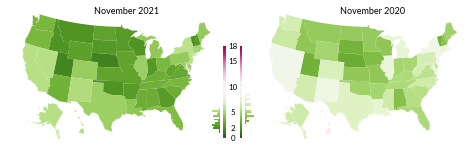

In [7]:
data = pd.DataFrame(unrate).T

states = list(set([i['STATE_NAME'] for i in m.states_info]))
vmin=0
vmax=18
cmap = plt.cm.PiYG_r
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-13, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_NAME']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [0, 2, 5, 10, 15, 18]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-13, 0.44, 0.4)]:
    for i in np.linspace(0,18,56):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/56, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(0,18,54)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/54, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/unemp_map.pgf', bbox_inches='tight')

In [8]:
numbers = {0: 'no', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 
           6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}

ltmonth = dtxt(data.index[-1])['mon1']
prmonth = dtxt(data.index[-13])['mon1']
d1 = data.iloc[-1].sort_values()
dap = data.loc['2020-04-01'].sort_values()
dpr = data.iloc[-13].sort_values()
a10 = len(d1[d1 > 10])
if a10 < 10:
    a10 = numbers[a10]
a10pr = len(dpr[dpr > 10])
if a10pr < 10:
    a10pr = numbers[a10pr]
a10ap = len(dap[dap > 10])
if a10ap < 10:
    a10ap = numbers[a10ap] 
    
a5pr = len(dpr[dpr > 5])
if a5pr < 10:
    a5pr = numbers[a5pr]
    
a5 = len(d1[d1 > 5])
if a5 < 10:
    a5 = numbers[a5]
    
h, l = {}, {}
for i in [1, 2, 3]:
    h[i] = f'{d1.index[-i]} ({d1.iloc[-i]}\%)'
    l[i] = f'{d1.index[i-1]} ({d1.iloc[i-1]}\%)'
    
text = (f'In {ltmonth}, {a10} states had an unemployment rate '+
        f'above ten percent, compared to {a10ap} states in April 2020. '+
        f'In {prmonth}, {a10pr} states had an unemployment rate '+
        f'above ten percent and only {a5pr} states had an unemployment '+
        f'rate above five percent. In {ltmonth}, {a5} states '+
        'have an unemployment rate above five percent. \n\n'+
        'The states with the highest unemployment rates in '+
        f'{ltmonth} are {h[1]}, {h[2]}, and {h[3]}. '+
        'The states with the lowest unemployment rates are '+
        f'{l[1]}, {l[2]}, and {l[3]}.')
write_txt(text_dir / 'state_unemp.txt', text)
print(text)   

In November 2021, no states had an unemployment rate above ten percent, compared to 41 states in April 2020. In November 2020, one states had an unemployment rate above ten percent and only 30 states had an unemployment rate above five percent. In November 2021, eight states have an unemployment rate above five percent. 

The states with the highest unemployment rates in November 2021 are New York (5.5\%), Nevada (5.4\%), and Alaska (5.4\%). The states with the lowest unemployment rates are Nebraska (1.2\%), Utah (1.4\%), and Vermont (1.8\%).


### Employment rate by state

In [9]:
data = pd.DataFrame(epop).T

/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


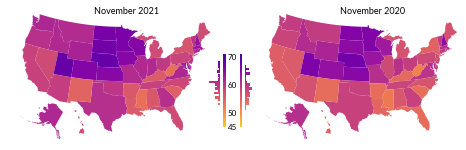

In [11]:
vmin=data.min().min()
vmax=data.max().max()
cmap = plt.cm.plasma_r
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-13, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_NAME']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [45, 50, 60, 70]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-13, 0.44, 0.4)]:
    for i in np.linspace(45,70,40):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/35, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(45,70,33)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/33, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/epop_map.pgf', bbox_inches='tight')

In [12]:
numbers = {0: 'no', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 
           6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}

ltmonth = dtxt(data.index[-1])['mon1']
prmonth = dtxt(data.index[-13])['mon1']
d1 = data.iloc[-1].sort_values()
dap = data.loc['2020-04-01'].sort_values()
dpr = data.iloc[-13].sort_values()
a60 = len(d1[d1 < 60])
if a60 < 10:
    a60 = numbers[a60]
a60pr = len(dpr[dpr < 60])
if a60pr < 10:
    a60pr = numbers[a60pr]
a60ap = len(dap[dap < 60])
if a60ap < 10:
    a60ap = numbers[a60ap] 
    
a65pr = len(dpr[dpr > 65])
if a65pr < 10:
    a65pr = numbers[a65pr]
    
a65 = len(d1[d1 > 65])
if a65 < 10:
    a65 = numbers[a65]
    
h, l = {}, {}
for i in [1, 2, 3]:
    h[i] = f'{d1.index[-i]} ({d1.iloc[-i]}\%)'
    l[i] = f'{d1.index[i-1]} ({d1.iloc[i-1]}\%)'
    
text = (f'In {ltmonth}, {a60} states had an employment rate '+
        f'above below 60 percent, compared to {a60ap} in April 2020. '+
        f'In {prmonth}, {a60pr} states had an employment rate '+
        f'below 60 percent and {a65pr} states had an unemployment '+
        f'rate above 65 percent. In {ltmonth}, {a65} states '+
        'have an employment rate above 65 percent. \n\n'+
        'The states with the highest employment rates in '+
        f'{ltmonth} are {h[1]}, {h[2]}, and {h[3]}. '+
        'The states with the lowest employment rates are '+
        f'{l[1]}, {l[2]}, and {l[3]}.')
write_txt(text_dir / 'state_emp.txt', text)
print(text)  

In November 2021, 23 states had an employment rate above below 60 percent, compared to 44 in April 2020. In November 2020, 33 states had an employment rate below 60 percent and four states had an unemployment rate above 65 percent. In November 2021, nine states have an employment rate above 65 percent. 

The states with the highest employment rates in November 2021 are Utah (67.9\%), Nebraska (67.8\%), and District of Columbia (67.2\%). The states with the lowest employment rates are Mississippi (53.1\%), West Virginia (53.2\%), and New Mexico (54.4\%).


### CPS-based measures

In [2]:
cols = ['LFS', 'BASICWGT', 'AGE', 'MONTH', 'YEAR', 'STATE']
query = '25 <= AGE <= 54'
df = pd.concat([pd.read_feather(cps_dir/f'cps{year}.ft', columns=cols).query(query) 
                for year in range(1989, 2022)])   

data = ((df.groupby(['YEAR', 'MONTH', 'STATE', 'LFS']).BASICWGT.sum() / 
        df.groupby(['YEAR', 'MONTH', 'STATE']).BASICWGT.sum())
          .unstack()['Employed'].unstack() * 100).dropna()

idx = pd.to_datetime(pd.DataFrame(data.index.values.tolist(), 
                                  columns=['YEAR', 'MONTH']).assign(DAY = 1))

data.index = idx

vmin=data.min().min()
vmax=data.max().max()

In [3]:
res = pd.DataFrame()
res['max'] = data.max()
res['min'] = data.min()
res['maxst'] = data.loc['2020-04-01':].max()
res['minst'] = data.loc['2020-04-01':].min()
res['latest'] = data.iloc[-1]

In [12]:
final = pd.DataFrame()
final['outer1'] = res['min']
final['range1'] = res['minst'] - res['min']
final['rangest'] = res['maxst'] - res['minst']
final['range2'] = res['max'] - res['maxst']
final['outer2'] = res['max'].max() - res['max']
final['latest'] = res['latest']
final = final.sort_values('latest', ascending=False)
final.index.name = 'name'
f1 = final.iloc[:17]
f1.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f1.to_csv(data_dir / 'state_pa_epop.csv', sep=';')
f2 = final.iloc[17:34]
f2.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f2.to_csv(data_dir / 'state_pa_epop2.csv', sep=';')
f3 = final.iloc[34:]
f3.loc[:,'y'] = [i * -1 + 0.08 for i in list(range(0, 17))]
f3.to_csv(data_dir / 'state_pa_epop3.csv', sep=';')
data.to_csv(data_dir / 'state_pa_epop_full.csv')

In [103]:
# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/home/brian/miniconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1405: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


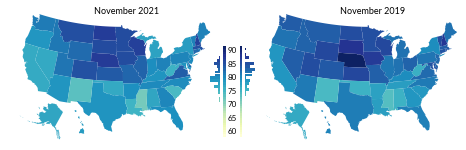

In [169]:
cmap = plt.cm.YlGnBu
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-25, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_ABBR']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_ABBR'] == 'HI':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_ABBR'] == 'AK':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [60, 65, 70, 75, 80, 85, 90]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-25, 0.44, 0.4)]:
    for i in np.linspace(58,92,40):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/35, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(58,92,33)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/33, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/pa_epop_map.pgf', bbox_inches='tight')